## LFV Limits from lepton dipole moments

In this notebook, we generate limits on LFV scalars and ALPs for the lepton dipole moments (assuming any and all anomalies have been resolved). For the magnetic dipole moments, we just assume that the current experimental error $\sigma_{a, \rm exp}$ on the dipole moments is valid, and that the contribution from these LFV particles satisfies $|\Delta a_{\rm LFV}| < 2\sigma_{a, \rm exp}$. For the electric dipole moments, since the current measurement is an upper bound $|d|_{\rm max}$ at $2\sigma$, we just assume that $|\Delta d_{\rm LFV}| < |d|_{\rm max}$.

In [1]:
#For numerics
import numpy as np

#For loading and saving data
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For setting root path
import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.append(root)
    
#Rate functions
from dipole_form_factors.formulae.dipole_moments import (da_sig_exp,
                                                         d_l,
                                                         a_i,
                                                         a_ij,
                                                         F2_ALP_photon,
                                                         d_i,
                                                         d_ij)
from phys.constants import me, mm, mt, ml

Some helper functions for opening the form-factor function files:

In [2]:
def str_to_tuple(str_tuple):
    return tuple([int(i) for i in str_tuple[1:-1].split(',')])

def extract_f_dict(file):
    df = pd.read_csv(file, index_col = 0)
    
    df.columns = [str_to_tuple(col) for col in df.columns]
    
    f_dict = {'mass': df.index.to_numpy(dtype = np.float64)}
    for col in df.columns:
        f_dict[col] = df[col].to_numpy(dtype = np.complex128)
    return f_dict

Extract the relevant form-factor functions:

In [3]:
func_names = ['f2_plus', 'f2_minus', 'f3_plus', 'f3_minus']
functions = []
for func_name in func_names:
    file = root + f'/dipole_form_factors/data/{func_name}.csv'
    functions.append(extract_f_dict(file))
f2p, f2m, f3p, f3m = functions

In [4]:
leptons = ['e', '\\mu', '\\tau']
processes = [(0, 0), (1, 1), (2, 2)]
sub_processes = [(0, 0, 0), (0, 0, 1), (0, 0, 2),
                 (1, 1, 0), (1, 1, 1), (1, 1, 2),
                 (2, 2, 0), (2, 2, 1), (2, 2, 2)]

def d_label(process):
    i, j, k = process
    return f'$d_{{{leptons[i]} {leptons[k]}}}~\\textrm{{lim.}}$'

m = f2p['mass']

mdm_limits = {}
edm_limits = {}
for mode in ['PC', 'chiral']:
    mdm_lim = {}
    edm_lim = {}
    for ALP in [False, True]:
        mdm_l = {'mass': m}
        edm_l = {'mass': m}
        particle = 'ALP' if ALP else 'scalar'
        for process in sub_processes:
            i, _, j = process
            
            g = [[0]*3 for i in range(3)]
            g[i][j] = 1 #find the limit on gij assuming all other couplings are zero
            mdm = a_ij(f2p, f2m, i, j, g = g, mode = mode, ALP = ALP)
            mdm_l[process] = np.sqrt(2*da_sig_exp[i]/np.abs(mdm))
            
            edm = d_ij(f2p, f2m, i, j, g = g, th = [[np.pi/4]*3]*3, d = [[np.pi/2]*3]*3 if ALP else [[0]*3]*3, ALP = ALP) #angle and phase are chosen to make edm maximum for constraints
            edm_l[process] = np.sqrt(d_l[i]/np.abs(edm))

        file = os.getcwd() + f'/data/mdm_{mode}_{particle}_limits.csv'
        df = pd.DataFrame(mdm_l)
        df.to_csv(file, index = False)
        
        file = os.getcwd() + f'/data/edm_{mode}_{particle}_limits.csv'
        df = pd.DataFrame(mdm_l)
        df.to_csv(file, index = False)
        
        mdm_lim[particle] = mdm_l
        edm_lim[particle] = edm_l
    mdm_limits[mode] = mdm_lim
    edm_limits[mode] = edm_lim

/Volumes/T7/Research/Thesis/phys/formulae/ALP_EFT.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  th[i,j] = np.arctan((mf[i]+mf[j])/(mf[i]-mf[j]) / np.tan(TH[i][j]))
/Volumes/T7/Research/Thesis/dipole_form_factors/formulae/dipole_moments.py:144: RuntimeWarning: invalid value encountered in sqrt
  exact-= (x+2)/3 * np.sqrt((x-4)*x)*np.log((np.sqrt(x)+np.sqrt(x-4))/2)


First, a helper function to plot the limits from $g-2$:

In [5]:
def plot_MDM_coupling_limits(i, ax = None, ALP = False):
    if not ax:
        fig, ax = plt.subplots()
    
    particle = 'ALP' if ALP else 'scalar'
    
    li = leptons[i]
    
    plot_labels = [f'$a_{{{leptons[i]} {leptons[j]}}}~\\textrm{{lim.}}$' for j in range(3)]
    phot_label = f'$a_{{{leptons[i]}\\gamma}}~\\textrm{{lim.}}$'
    
    #calculate absolute minimum to shade in
    minimum = 1e16
    
    #PC plots
    for j in range(3):
        ax.plot(m, mdm_limits['PC'][particle][(i,i,j)],
                color = colors[j],
                label = plot_labels[j])
    
        
        minimum = np.minimum(minimum, mdm_limits['PC'][particle][(i,i,j)])
        
    #chiral plots
    for j in range(3):
        ax.plot(m, mdm_limits['chiral'][particle][(i,i,j)],
                color = colors[j],
                linestyle = 'dashed')
    
        minimum = np.minimum(minimum, mdm_limits['chiral'][particle][(i,i,j)])

#     minimum = np.minimum(minimum, mdm_limits['chiral'][particle][process])

    
    ax.fill_between(m, minimum, 1e10, color = 'yellow', alpha = 0.05)
        
    legend = ax.legend(fancybox = False,
                       fontsize = 10,
                       facecolor = 'white',
                       edgecolor = 'black',
                       loc = 'lower right')
    ax.add_artist(legend)
    
    #This is only for the first plot
    ax.plot([1000], color = 'grey', label = f'$\\textrm{{pure {particle}}}$')
    ax.plot([1000], color = 'grey', label = f'$\\chi\\textrm{{ {particle}}}$', linestyle = 'dashed')

    particle_handles, particle_labels = plt.gca().get_legend_handles_labels()
    particle_handles, particle_labels = particle_handles[-2:], particle_labels[-2:]

    ax.legend(particle_handles, particle_labels,
              frameon = False,
              fontsize = 8,
              loc = 'lower left')

    ax.tick_params(direction = 'in', which = 'both')
    ax.grid()

    ax.set_xscale('log')
    
    ax.set_xlim(1e0, 1e2 if ALP else 1e3)
    if ALP:
        ax.set_xlabel("$m_a~[\\textrm{GeV}]$", fontsize = 14)
    else:
        ax.set_xlabel("$m_\\varphi~[\\textrm{GeV}]$", fontsize = 14)

    ax.set_yscale('log')
    ymin, ymax = [1e-4, 1e3] if ALP else [1e-7, 1e0]
    ax.set_ylim(ymin, ymax)

    if ALP:
        ylabel =f'$C_{{{li} \\ell}}/\\Lambda~[\\textrm{{TeV}}]^{{-1}}$'
    else:
        ylabel =f'$g_{{{li} \\ell}}$'
    ax.set_ylabel(ylabel, fontsize = 14)
    
    return ax

Here, we can look at the limits. First, for scalars:

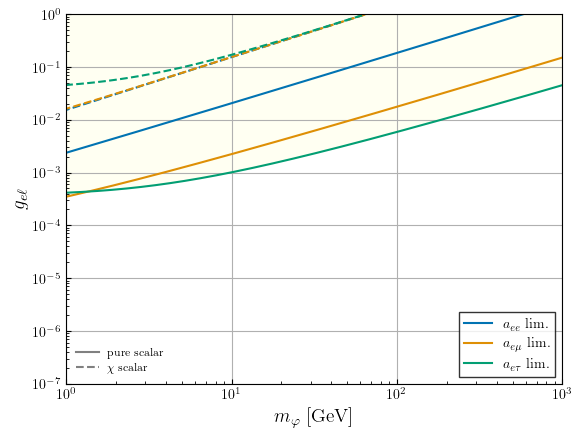

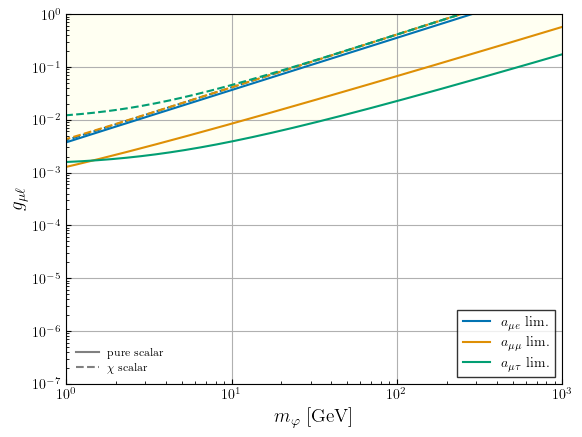

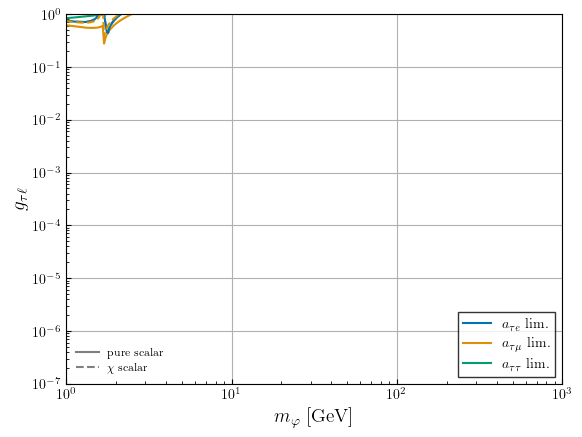

In [6]:
for k in range(3):
    plot_MDM_coupling_limits(k)

Now, for ALPs:

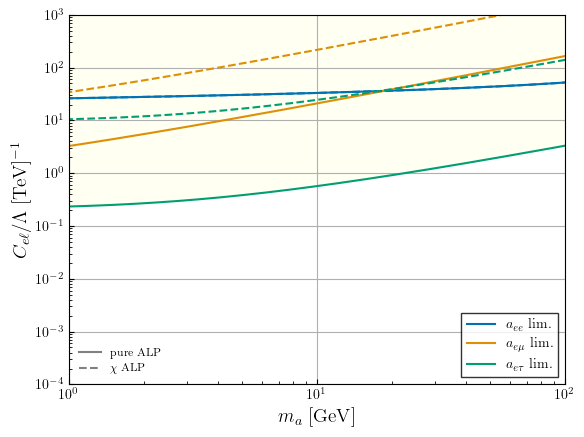

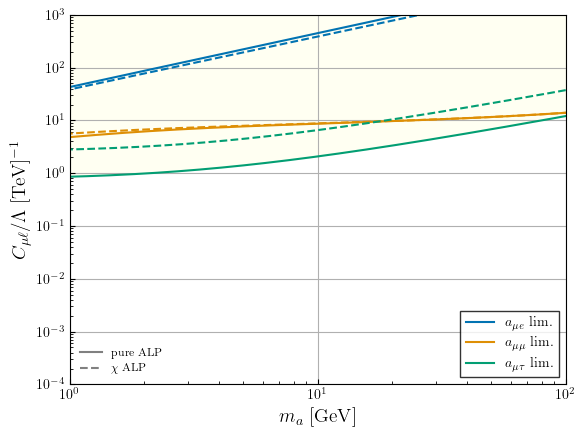

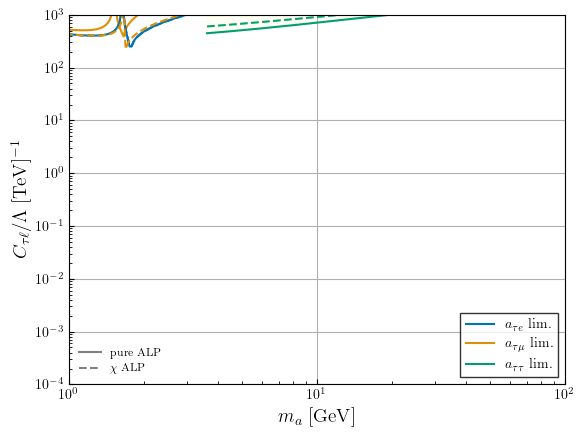

In [7]:
for k in range(3):
    plot_MDM_coupling_limits(k, ALP = True)

We see that the limits from $a_\tau$ are so weak that we opt not to include them. Instead, we generate a figure which shows the limits on LFV scalars and ALPs from the electron and muon dipole moments _assuming_ the anomalies are resolved.

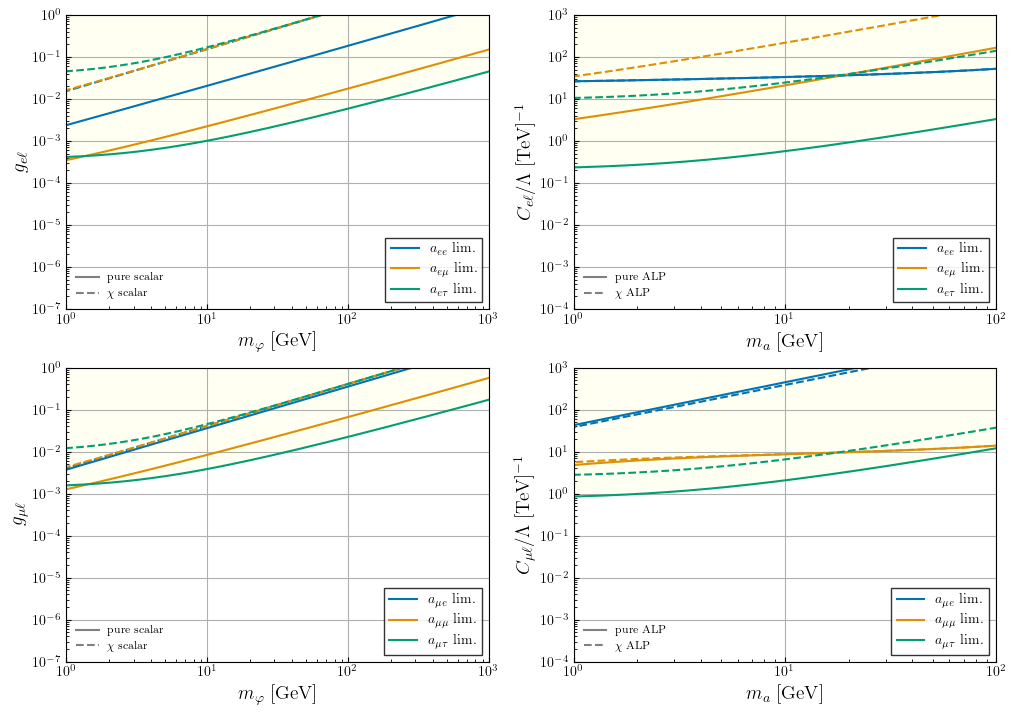

In [8]:
fig = plt.figure(figsize = (12, 8.4))
gs = GridSpec(2, 2, figure = fig, hspace = 0.2, wspace = 0.2)

for k in range(2):
    ax = fig.add_subplot(gs[2*k])
    plot_MDM_coupling_limits(k, ax = ax)
    
    ax = fig.add_subplot(gs[2*k+1])
    plot_MDM_coupling_limits(k, ax = ax, ALP = True)
    
plt.savefig(root + '/figures/chapter3/LFV_MDM_limits.pdf', format = 'pdf')

Similarly to the magnetic dipole moment, we can compute the limits from the leading bounds on the electric dipole moments of the leptons. These limits only apply when the interaction is CP-violating, so we encode this by indicating the bound is on $g_{ij}\sqrt{\sin{2\theta_{ij}}\cos{\delta_{ij}}}$ for the scalar and $C_{ij}\sqrt{\sin{2\Theta_{ij}}\sin{\Delta_{ij}}}$ for the ALP.

In [9]:
def plot_EDM_coupling_limits(i, ax = None, ALP = False):
    if not ax:
        fig, ax = plt.subplots()
    
    particle = 'ALP' if ALP else 'scalar'
    
    li = leptons[i]
    
    plot_labels = [f'$d_{{{leptons[i]} {leptons[j]}}}~\\textrm{{lim.}}$' for j in range(3)]
    phot_label = f'$d_{{{leptons[i]}\\gamma}}~\\textrm{{lim.}}$'
    
    #calculate absolute minimum to shade in
    minimum = 1e16
    
    #PC plots
    for j in range(3):
        ax.plot(m, edm_limits['PC'][particle][(i,i,j)],
                color = colors[j],
                label = plot_labels[j])
        
        minimum = np.minimum(minimum, edm_limits['PC'][particle][(i,i,j)])
    
    ax.fill_between(m, minimum, 1e10, color = 'yellow', alpha = 0.05)
        
    legend = ax.legend(fancybox = False,
                       fontsize = 10,
                       facecolor = 'white',
                       edgecolor = 'black',
                       loc = 'lower right')
    ax.add_artist(legend)

    ax.tick_params(direction = 'in', which = 'both')
    ax.grid()

    ax.set_xscale('log')
    
    ax.set_xlim(1e0, 1e2*(1 if ALP else 10))
    if ALP:
        ax.set_xlabel("$m_a~[\\textrm{GeV}]$", fontsize = 14)
    else:
        ax.set_xlabel("$m_\\varphi~[\\textrm{GeV}]$", fontsize = 14)

    ax.set_yscale('log')
    ymin, ymax = [1e-4, 1e3] if ALP else [1e-7, 1e0]
    ax.set_ylim(ymin, ymax)

    if ALP:
        ylabel =f'$C_{{{li} \\ell}}\sqrt{{\sin{{2\\Theta_{{ij}}}}\sin{{\\Delta_{{ij}}}}}}/\\Lambda~[\\textrm{{TeV}}]^{{-1}}$'
    else:
        ylabel =f'$g_{{{li} \\ell}}\sqrt{{\sin{{2\\theta_{{ij}}}}\cos{{\\delta_{{ij}}}}}}$'
    ax.set_ylabel(ylabel, fontsize = 14)
    
    return ax

Now we can look at the limits for the scalar:

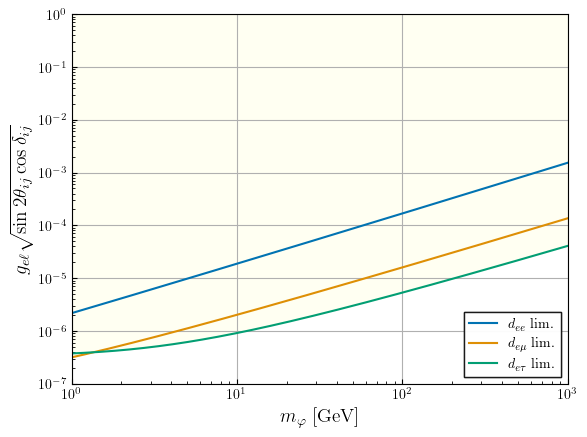

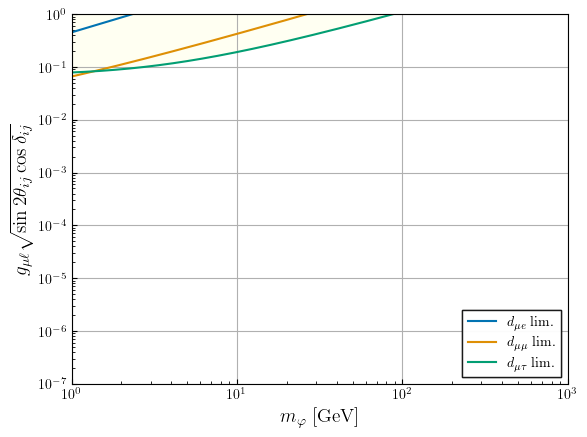

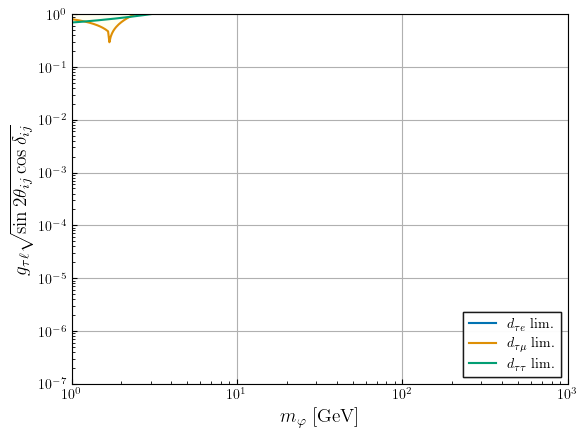

In [10]:
for k in range(3):
    plot_EDM_coupling_limits(k)

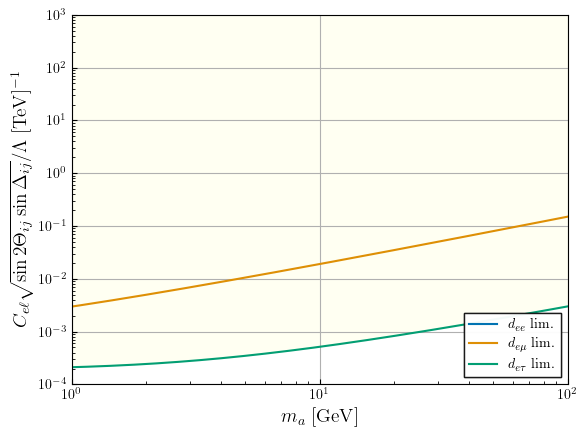

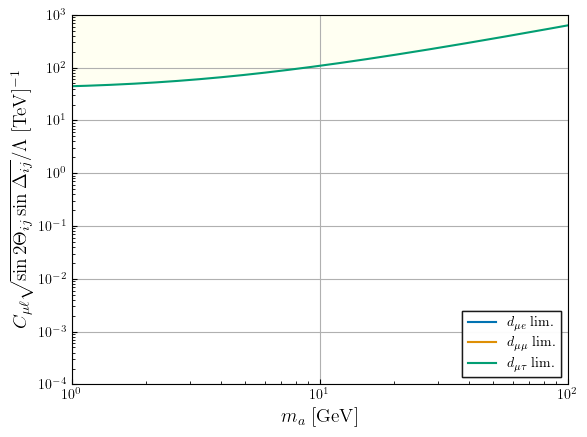

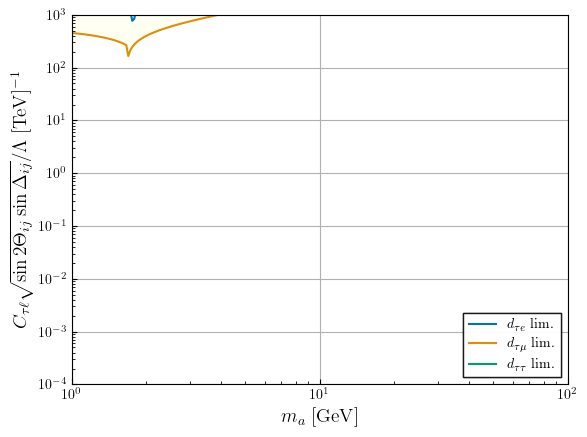

In [11]:
for k in range(3):
    plot_EDM_coupling_limits(k, ALP = True)

In this case, we see that the limits placed from the electric dipole moment are only potentially stronger from the electron EDM, so we generate a figure which includes that:

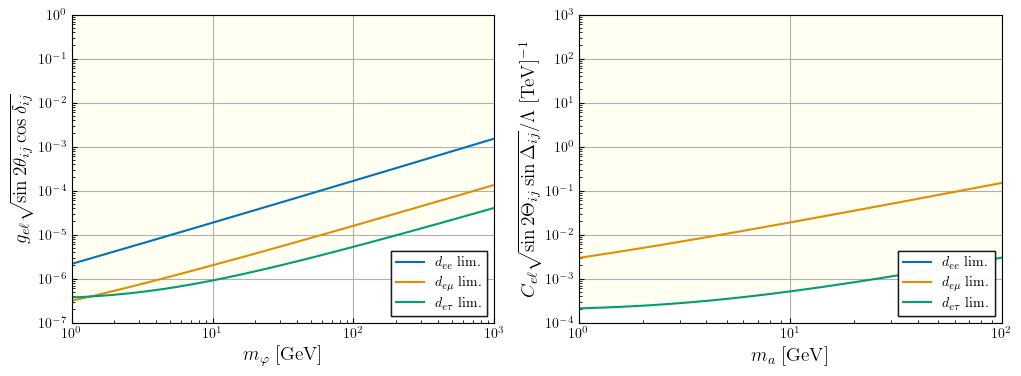

In [12]:
fig = plt.figure(figsize = (12, 4))
gs = GridSpec(1, 2, figure = fig, wspace = 0.2)

ax = fig.add_subplot(gs[0])
plot_EDM_coupling_limits(0, ax = ax)
    
ax = fig.add_subplot(gs[1])
plot_EDM_coupling_limits(0, ax = ax, ALP = True)
    
plt.savefig(root + '/figures/chapter3/LFV_EDM_limits.pdf', format = 'pdf')